In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas import DataFrame, Series

def get_returns(file_path):
    data_frame = pd.read_excel(file_path, index_col='Date', parse_dates=['Date'], squeeze=False)
    returns = data_frame['Change %'].str.rstrip(' %').astype('float')
    returns.dropna(inplace=True)
    returns.name = 'Total Returns'
    return returns

def get_cumulative_returns(returns):
    return (((returns / 100) + 1).cumprod() - 1) * 100

def get_returns_extrema(returns, n):
    sorted = returns.sort_values()
    top = sorted.head(n=n)
    bottom = sorted.tail(n=n)
    return pd.concat([top, bottom])

def get_rolling_calculations(returns, callback, rolling_period=30, mult_factor=1, is_series=True):
    calcs = {}
    count = returns.count() if is_series else returns.count()['Total Returns Index']
    last_index = count - rolling_period
    for index in range(last_index):
        date = returns.index[index+rolling_period]
        calc = callback(returns.iloc[index:index+rolling_period])*mult_factor
        calcs[date] = calc
    return Series(calcs)

def calculate_betas(returns):
    ols = sm.OLS(returns['Total Returns Stock'], sm.add_constant(returns['Total Returns Index']))
    fitted = ols.fit()
    return fitted.params['Total Returns Index']

In [2]:
# ETL
stock_file_path = 'mdt_historical_quotes.xlsx'
index_file_path = 'spy_historical_quotes.xlsx'

stock_returns = get_returns(stock_file_path)
index_returns = get_returns(index_file_path)
returns = pd.merge(index_returns, stock_returns,on='Date', suffixes=(' Index', ' Stock'))

<AxesSubplot:>

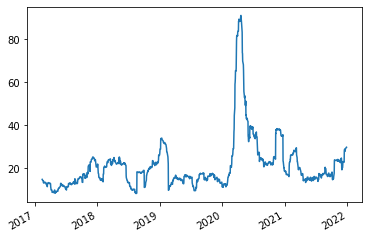

In [3]:
# Series Analysis
count_returns_extrema = 5
annualize_std_factor = 252**.5

stock_cumulative_returns = get_cumulative_returns(stock_returns)
stock_returns_extrema = get_returns_extrema(stock_returns,n=count_returns_extrema)
stock_rolling_stds = get_rolling_calculations(stock_returns,Series.std,mult_factor=annualize_std_factor)

stock_rolling_stds.plot()

<AxesSubplot:>

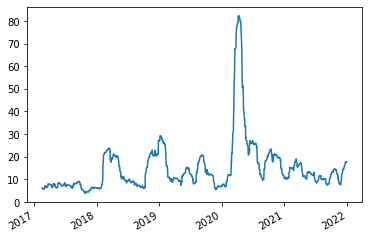

In [4]:
index_cumulative_returns = get_cumulative_returns(index_returns)
index_returns_extrema = get_returns_extrema(index_returns,n=count_returns_extrema)
index_rolling_stds = get_rolling_calculations(index_returns,Series.std,mult_factor=annualize_std_factor)
index_rolling_stds.plot()

<AxesSubplot:>

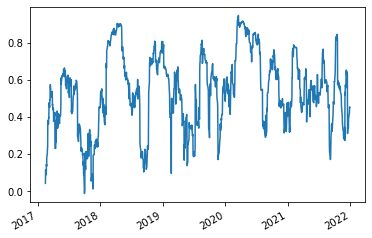

In [5]:
# DataFrame Analysis
corrs_callback = lambda returns: DataFrame.corr(returns).iloc[1,0]
rolling_corrs = get_rolling_calculations(returns,corrs_callback,is_series=False,rolling_period=30)
rolling_corrs.plot()

C:\Users\bwynn\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<AxesSubplot:>

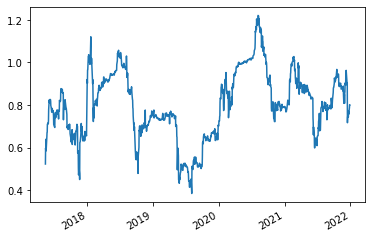

In [6]:
rolling_betas = get_rolling_calculations(returns,calculate_betas,is_series=False,rolling_period=90)
rolling_betas.plot()

In [7]:
rolling_betas.name = 'Rolling Betas'
index_cumulative_returns.name = 'Cumulative Returns Index'
betas_vs_index = pd.merge(rolling_betas,index_cumulative_returns,left_index=True,right_index=True)

C:\Users\bwynn\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
C:\Users\bwynn\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

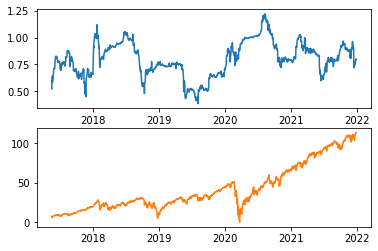

In [8]:
fig, axes = plt.subplots(nrows=2,sharex=True)
betas_vs_index.plot(ax=axes[0],legend=False,subplots=True)
betas_vs_index.plot(ax=axes[1],legend=False,subplots=True)